In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import matplotlib.colors as mcolors

import umap
import umap.plot
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from bioinfokit.visuz import cluster
from sklearn import datasets
from scipy.spatial import ConvexHull

In [2]:
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (14, 5),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}

plt.rcParams.update(params)

In [3]:
luce = pd.read_csv("datasets/Leukemia.csv")
colors = luce.iloc[:,-1] # categorical variable to color the points
luce = luce.iloc[:,1:-1] # numerical varibables

Standard Scale 

The scaling step ensures equal contribution from each variable, which is especially important for datasets containing heterogeneous features with highly variable ranges or distinct units, e.g., patient clinical data or environmental factors data.

In [4]:
scaler = StandardScaler()
scaler.fit(luce)

luce = scaler.transform(luce)

# Uniform Manifold Approximation and Projection - UMAP

PCA factorize the matrix, while UMAP build neighbor graph in the original space and try to find a similar graph in lower dimension. the construcition of  the high dimensional graph is what make UMAP unique and different from other graph based algorithm as t-sne. 

The main intuition is rely of the the nerve theoren. Basically *"Each data point is called 0-simplex and the nerve theorem state that the shape of the data can be approximate this 0-simplex with their neighbor forming 1-simplex or 2-simplex (2 units and so on)."*

the umap extend a radius around each point and generation connection as radius intersection ( In reality we have different problem here because in low density region we cannot be able to build the graph because none of the neighbor is reached in the radius). The smarter solution that is adopted in UMAP is to use a flexibile radius which is math proofed and allows to build graph in every possible scenarios! So the connection in the graph is weighted according to the radial distance of neighbours. the low dimensional graph is constructed then according to the weight of the edges, points connected by heavy edge are more likely to be connected in low dimensional space. 

Key Differences Between tSNE and UMAP:
First UMAP is based on solid mathematical principles and hence very different from tSNE which is a pure Machine Learning semi-empirical algorithm.

1) UMAP uses exponential probability distribution in high dimensions but not necessarily Euclidean distances like tSNE but rather any distance can be plugged in. In addition, the probabilities are not normalized: 

$$p_{i \mid j} = e^{-\frac{d(x_{i}, x_{j}) - p_{i}}{\sigma_{i} }}$$

Here ρ is an important parameter that represents the distance from each i-th data point to its first nearest neighbor. This ensures the local connectivity of the manifold. In other words, this gives a locally adaptive exponential kernel for each data point, so the distance metric varies from point to point.

2) UMAP does not apply normalization to either high- or low-dimensional probabilities and it turns out that the absence of normalization, dramatically reduces time of computing the high-dimensional graph since summation or integration is a computationally expensive procedure. 

3) UMAP uses the number of nearest neighbors instead of perplexity. UMAP defines the number of nearest neighbor k without the log2 function, i.e. as follows: 

$$k = 2^{\sum_{i} p_{ij}}$$ 

4) UMAP uses a slightly different symmetrization of the high-dimensional probability.

5) UMAP uses binary cross-entropy (CE) as a cost function instead of the KL-divergence like tSNE does.

6)  that this additional (second) term in the CE cost function makes UMAP capable of capturing the global data structure in contrast to tSNE that can only model the local structure at moderate perplexity values. 

$$CE(X,Y)= \sum_{i}\sum_{j}[p_{ij}(X)log(\frac{p_{ij}(X)}{q_{ij}(Y)}) + (1 - p_{ij}(X)) log(\frac{1-p_{ij}(X)}{1-q_{ij}(Y)}]$$

7) UMAP assigns initial low-dimensional coordinates using Graph Laplacian in contrast to random normal initialization used by tSNE. This, however, should make a minor effect for the final low-dimensional representation, this was at least the case for tSNE. However, this should make UMAP less changing from run to run since it is not a random initialization anymore.

8) Finally, UMAP uses the Stochastic Gradient Descent (SGD) instead of the regular Gradient Descent (GD) like tSNE / FItSNE, this both speeds up the computations and consumes less memory.

So the KL-divergence makes tSNE impossible to preserve global distances when performing dimension reduction. By simply plotting the cost functions of tSNE (KL-divergence) and UMAP (Cross Entropy (CE)) against each other we can observe that at large distances, X, between points in high dimensions, the distances, Y, between points in low dimensions are not guaranteed to be large in sense of the KL penalty. As long as tSNE uses KL-divergence as cost function, it can not compete against UMAP in global distance preservation.

the math behind those two is very different. While tSNE is purely for visualization purposes, UMAP is much more than that. The most important probably is that it is fine to cluster on UMAP components while this is not the case for tSNE.

- Parameters:

n_neighbors: it determines the number of neighboring points used in local approximations of manifol structure. larger values will result in more global structure being preserved at the loss of detailed local structure (range 5,50).

min_dist: controls how tightly the embdding is allowed compress poitns toghether larger values ensure embdedd points are more evenly distributed. smaller values allow the algortihm to optimise more accurately. range(0.0001, 0.5)


In [5]:
df = datasets.load_digits()
x = pd.DataFrame(df.data, columns=[ f"ft_{i}" for i in range(64)])
y = df.target

reducer = umap.UMAP(random_state=42, 
                    n_neighbors= 6 , 
                    metric='euclidean',
                    n_components=2)

reducer.fit(x.values)
embedding = reducer.transform(x.values)

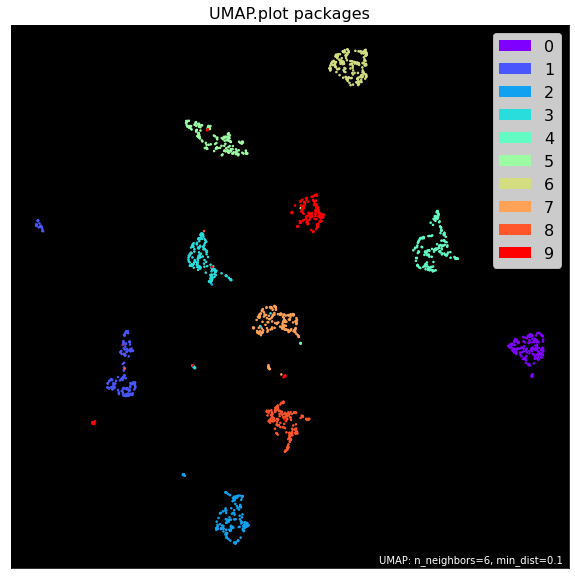

In [6]:
fig, axes= plt.subplots(1,1, figsize=(10,10))
umap.plot.points(reducer, 
                 labels=y, 
                 theme='fire', 
                 ax =axes, 
                 show_legend=True)

axes.set_title('UMAP.plot packages')
plt.show()

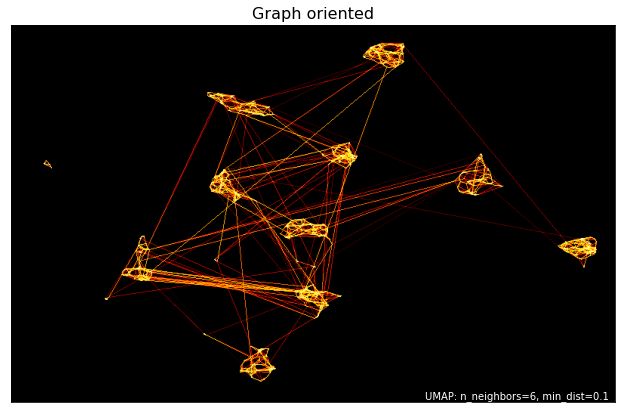

In [7]:
ax = umap.plot.connectivity(reducer,
                            theme='fire',
                           width=800,
                           height=500)

ax.set_title("Graph oriented")
plt.show()

# T-SNE

PCA is a linear dimension reduction technique that seeks to maximize variance and preserves large pairwise distances. In other words, things that are different end up far apart. This can lead to poor visualization especially when dealing with non-linear manifold structures. Think of a manifold structure as any geometric shape like: cylinder, ball, curve, etc. t-SNE differs from PCA by preserving only small pairwise distances or local similarities whereas PCA is concerned with preserving large pairwise distances to maximize variance. PCA preserve large pariwise distances in the map, but canno cacth the structure of the whole data

T-SNE is an unsupervised, randomized algorithm, used only for visualization. it applies a non-linear dimensionality reduction technique where the focus is on keeping the very similar data points close together in lower-dimensional space, it preserves the local structure of the data using student t-distribution to compute the similarity between two points in lower-dimensional space and lastly outliers do not impact t-SNE.

*“t-Distributed stochastic neighbor embedding (t-SNE) minimizes the divergence between two distributions: a distribution that measures pairwise similarities of the input objects and a distribution that measures pairwise similarities of the corresponding low-dimensional points in the embedding”.* Essentially what this means is that it looks at the original data that is entered into the algorithm and looks at how to best represent this data using less dimensions by matching both distributions. 

- Algorithm:

Step 1: Find the pairwise similarity between nearby points in a high dimensional space.
t-SNE converts the high-dimensional Euclidean distances between datapoints xᵢ and xⱼ into conditional probabilities P(j|i). The probability density of a pair of a point is proportional to its similarity. For nearby data points, p(j|i) will be relatively high, and for points widely separated, p(j|i) will be minuscule. Think of a bunch of data points scattered on a 2D space. For each data point (xi) we’ll center a Gaussian distribution over that point. Then we measure the density of all points (xj) under that Gaussian distribution. Then renormalize for all points. This gives us a set of probabilities (Pij) for all points. Those probabilities are proportional to the similarities. All that means is, if data points x1 and x2 have equal values under this gaussian circle then their proportions and similarities are equal and hence you have local similarities in the structure of this high-dimensional space.

Step 2: Step 2 is similar to step 1, but instead of using a Gaussian distribution you use a Student t-distribution with one degree of freedom. We map each point in high dimensional space to a low dimensional map based on the pairwise similarity of points in the high dimensional space. This gives us a second set of probabilities (Qij) in the low dimensional space. 

Step 3: Find a low-dimensional data representation that minimizes the mismatch between Pᵢⱼ (original space) and qᵢⱼ (low dimensional space) using gradient descent based on Kullback-Leibler divergence(KL Divergence):

$$ {\displaystyle D_{\text{KL}}(P\parallel Q)=-\sum _{x\in {\mathcal {X}}}P(x)\log \left({\frac {Q(x)}{P(x)}}\right)} $$

The KL divergence is a measure of how different one probability distribution from a second.

Step 4: Use Student-t distribution to compute the similarity between two points in the low-dimensional space. t-SNE uses a heavy-tailed Student-t distribution with one degree of freedom to compute the similarity between two points in the low-dimensional space rather than a Gaussian distribution.

- Optimisation step:

The kullback-leibler divergense is not symmetric, different types of error in the paiwise distances in the low-dimensional map are not weighted equally. the solution is found by using **gradient descent**.
the strongly reperls dissimilar data point do not go to infinity thanks to the early compression that maps points to stay close toghether at the start of the optimization, implemented by adding ad additional l2 penalty to the cost function that is proportional to the sum of square distances of the map points from the origin.

- Perpexlity:

The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. Larger datasets usually require a larger perplexity. Consider selecting a value between 5 and 50. Different values can result in significantly different results. Perplexity balances the attention t-SNE gives to local and global aspects of the data and can have large effects on the resulting plot. One can interpret this as at large σ tSNE does account for long-range interactions between the data points.



<img src="good_chartjunk.png">



- Learning_rate:

The learning rate for t-SNE is usually in the range [10.0, 1000.0]. If the learning rate is too high, the data may look like a ‘ball’ with any point approximately equidistant from its nearest neighbours. If the learning rate is too low, most points may look compressed in a dense cloud with few outliers. If the cost function gets stuck in a bad local minimum increasing the learning rate may help.

- n_iter:

Maximum number of iterations for the optimization. Should be at least 250. How much of a difference do those values make? In our experience, the most important thing is to iterate until reaching a stable configuration. so low learning rate but high n_iter.

- Drawbacks:

it is very hard to interpret, the choice of the hyperparameter is critical and it does not preserve the global structure of the data, cluster size and inter-cluster distance are not meaningful and artifacts may appear in the data and lastly is very computation expensive so it is slow on large datasets. 

Cluster sizes in a t-SNE plot mean nothing: The t-SNE algorithm adapts its notion of “distance” to regional density variations in the data set. As a result, **it naturally expands dense clusters, and contracts sparse ones**, evening out cluster sizes. Again distances between well-separated clusters in a t-SNE plot may mean nothing. 

tSNE does not scale well for rapidly increasing sample sizes, tSNE does not preserve global data structure, meaning that only within cluster distances are meaningful while between cluster similarities are not guaranteed, therefore it is widely acknowledged that clustering on tSNE is not a very good idea. tSNE performs a non-parametric mapping from high to low dimensions, meaning that it does not leverage features (aka PCA loadings) that drive the observed clustering. tSNE can not work with high-dimensional data directly, Autoencoder or PCA are often used for performing a pre-dimensionality reduction before plugging it into the tSNE. tSNE consumes too much memory for its computations which becomes especially obvious when using large perplexity hyperparameter since the k-nearest neighbor initial step becomes less efficient and important for time reduction.

In [8]:
def tsnes(data, p= [2,5,25,50], component=2):
    res = []
    for ps in p:
        tsne = TSNE(random_state=42,
                    n_components=component, 
                    verbose=0, 
                    perplexity=ps, 
                    n_iter=1000)

        emb = tsne.fit_transform(data)
        df = pd.DataFrame(emb, columns = [f'PC{i+1}' for i in range(component)])
        res.append(df)
    return res

In [9]:
def encircle(x,y, ax=None, **kw):
    if not ax: ax=plt.gca()
    p = np.c_[x,y]
    hull = ConvexHull(p)
    poly = plt.Polygon(p[hull.vertices,:], **kw)
    ax.add_patch(poly)

In [10]:
df = pd.read_csv("datasets/US_road_conditions.csv")
tmp = []
for state in np.unique(df.State):
    row=df[df.State == state].groupby('System').sum().transpose()
    row['State']=state
    tmp.append(row)
df = pd.concat(tmp)
df.reset_index(inplace=True, drop=True)

# or 
df = pd.read_csv("datasets/US_road_conditions.csv")
df_p=pd.get_dummies(df.iloc[:,1:])
y = df.State

df_n = df.iloc[:,1:-1]
colors__ = df.iloc[:,-1]
perplexities = [2,10,20,30]
list_tsnes = tsnes(df_p, perplexities)

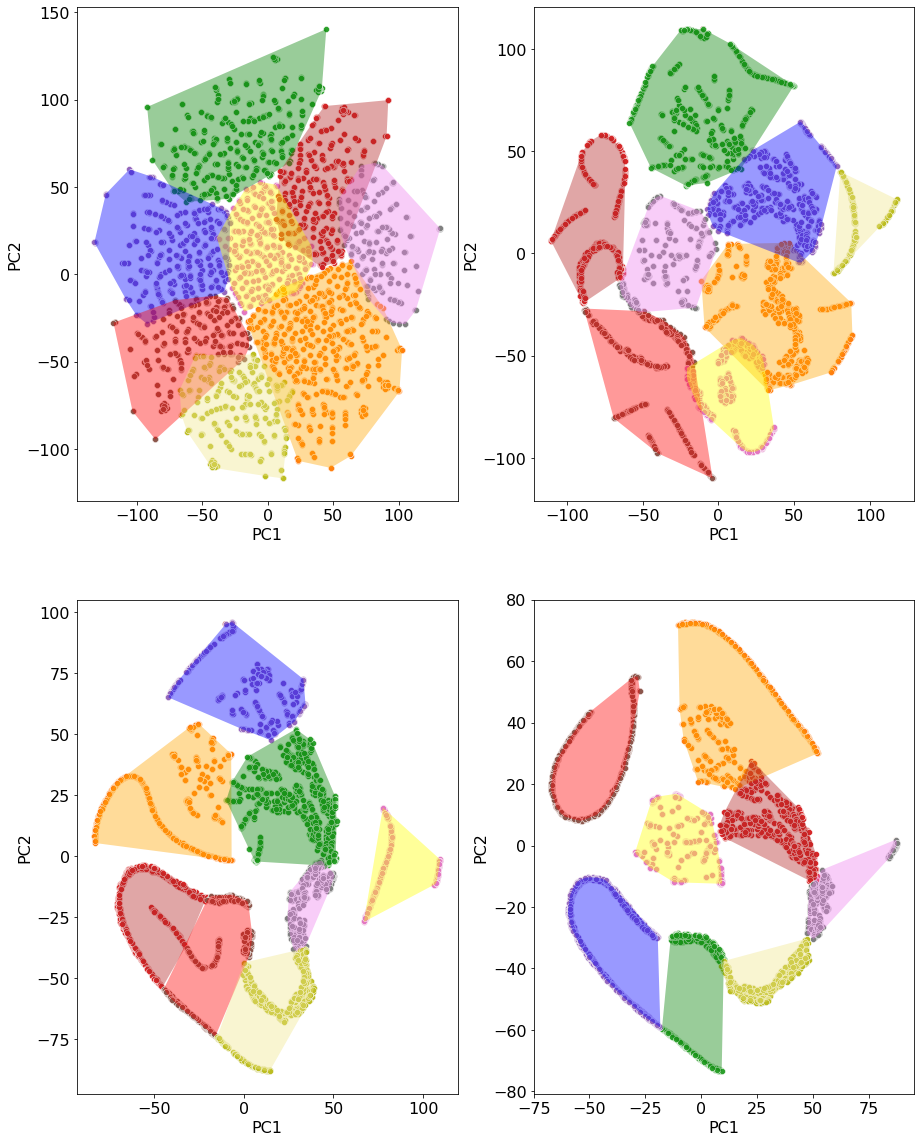

In [11]:
fig, axes= plt.subplots(2,2, figsize=(15,20))

g1 = sns.scatterplot(ax = axes[0][0],
                    data=list_tsnes[0], 
                    x='PC1', 
                    y = "PC2", 
                    hue= colors__, palette='Reds', legend=False)

g2 = sns.scatterplot(ax = axes[0][1],
                    data=list_tsnes[1], 
                    x='PC1', 
                    y = "PC2", 
                    hue= colors__, palette='Reds', legend=False)

g3 = sns.scatterplot(ax = axes[1][0],
                    data=list_tsnes[2], 
                    x='PC1', 
                    y = "PC2", 
                    hue= colors__, palette='Reds', legend=False)

g4 = sns.scatterplot(ax = axes[1][1],
                    data=list_tsnes[3], 
                    x='PC1', 
                    y = "PC2", 
                    hue= colors__, palette='Reds', legend=False)


col = ['orange','green','firebrick','blue','red','yellow','violet','khaki','white','snow',"brown"]
clusters_ = 8
clusters = AgglomerativeClustering(n_clusters=clusters_)
results = clusters.fit(list_tsnes[0])
for group in np.unique(results.labels_):
    sns.scatterplot(ax = axes[0][0],  data = list_tsnes[0].loc[results.labels_ == group,:], 
                    x= 'PC1',  y='PC2', label = str(group), legend=False)
    encircle(x= list_tsnes[0].loc[results.labels_ == group, 'PC1'].values.tolist(), 
             y= list_tsnes[0].loc[results.labels_ == group, 'PC2'].values.tolist(),  
             alpha=0.4, linewidth=1, fc=col[group], ax = axes[0][0])
    
clusters_ = AgglomerativeClustering(n_clusters=clusters_)
results = clusters.fit(list_tsnes[1])
for group in np.unique(results.labels_):
    sns.scatterplot(ax = axes[0][1],  data = list_tsnes[1].loc[results.labels_ == group,:], 
                    x= 'PC1',  y='PC2', label = str(group), legend=False)
    encircle(x= list_tsnes[1].loc[results.labels_ == group, 'PC1'].values.tolist(), 
             y= list_tsnes[1].loc[results.labels_ == group, 'PC2'].values.tolist(),  
             alpha=0.4, linewidth=1, fc=col[group], ax = axes[0][1])
    
clusters_ = AgglomerativeClustering(n_clusters=clusters_)
results = clusters.fit(list_tsnes[2])
for group in np.unique(results.labels_):
    sns.scatterplot(ax = axes[1][0],  data = list_tsnes[2].loc[results.labels_ == group,:], 
                    x= 'PC1',  y='PC2', label = str(group), legend=False)
    encircle(x= list_tsnes[2].loc[results.labels_ == group, 'PC1'].values.tolist(), 
             y= list_tsnes[2].loc[results.labels_ == group, 'PC2'].values.tolist(),  
             alpha=0.4, linewidth=1, fc=col[group], ax = axes[1][0])


clusters_ = AgglomerativeClustering(n_clusters=clusters_)
results = clusters.fit(list_tsnes[3].values)
for group in np.unique(results.labels_):
    sns.scatterplot(ax = axes[1][1],  data = list_tsnes[3].loc[results.labels_ == group,:], 
                    x= 'PC1',  y='PC2', label = str(group), legend=False)
    encircle(x= list_tsnes[3].loc[results.labels_ == group, 'PC1'].values.tolist(), 
             y= list_tsnes[3].loc[results.labels_ == group, 'PC2'].values.tolist(),  
             alpha=0.4, linewidth=1, fc=col[group], ax = axes[1][1])

plt.show()

# PCA

Project orthogonally a dataset on p-dimensional points into a r-dimensional space, lower than p. The new coordinates are called principal components, each component is defined by being ortoghonal to the others and having the highest possible variance. This is done first centering the data, compute the covariance matrix, extract the eigen vectors and compute the proportions of variances.


PCA is an unsupervised, deterministic algorithm used for feature extraction as well as visualizatio, it applies a linear dimensionality reduction technique where the focus is on keeping the dissimilar points far apart in a lower-dimensional space. So PCA transforms the original data to a new data by preserving the variance in the data using eigenvalues (sensitive to outliers).

In [12]:
def explained_v(pca):
    print(f"""Variance Explained: {[ round (i,3) for i in pca.explained_variance_ratio_.tolist()[0:10]]}\ntotal components {len(pca.explained_variance_ratio_.tolist())}""")

In [13]:
components = 10

pca = PCA(n_components=components)

pca_emb = pca.fit_transform(luce)
pca_df = pd.DataFrame(pca_emb, columns = [f'PC{i+1}' for i in range(components)])

explained_v(pca)

Variance Explained: [0.149, 0.094, 0.047, 0.04, 0.034, 0.032, 0.027, 0.024, 0.022, 0.021]
total components 10


In [14]:
def show_values_on_bars(axs, h_v="v", space_x=0.12,space_y=0.1, fontdict=None):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2 + space_x
                _y = p.get_y() + p.get_height() + (space_y)
                if not np.isnan(p.get_width()):
                    value = round(p.get_height(),2)
                    if fontdict: ax.text(_x, _y, value, ha="left", fontdict=fontdict)
                    else: ax.text(_x, _y, value, ha="left")
        elif h_v == "h":
            for p in ax.patches:
                try:
                    _x = p.get_x() + p.get_width() + space_x
                    _y = p.get_y() + p.get_height() + space_y
                    if not np.isnan(p.get_width()):
                        value = round(p.get_width(),2)
                        if value < 0: _x-=0.27
                        if fontdict: ax.text(_x, _y, value, ha="left", fontdict=fontdict)
                        else: ax.text(_x, _y, value, ha="left")
                except: print(f'Error while preparing {str(p)}')
    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

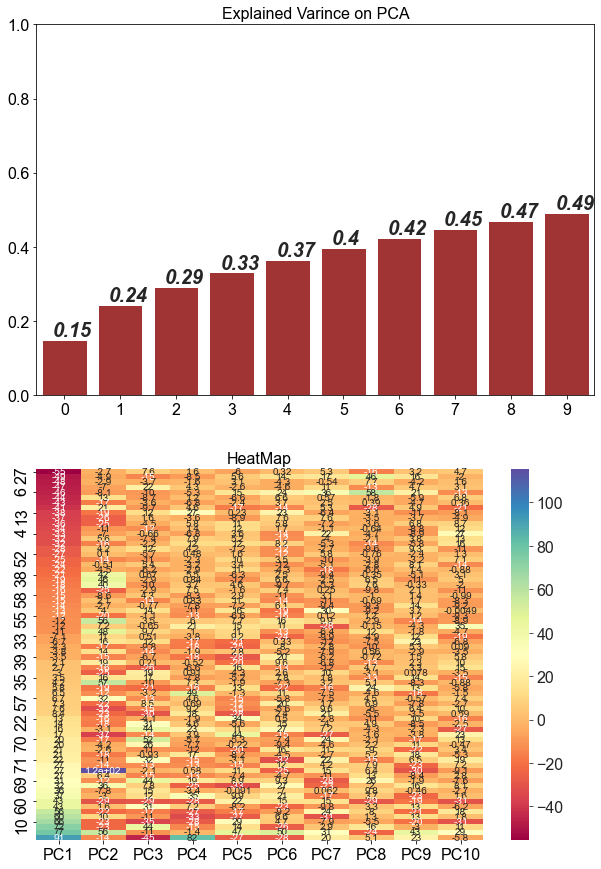

In [15]:
fig, axes= plt.subplots(2,1, figsize=(10,15))
sns.set_style('whitegrid')


############### Explained Variance
_y= np.cumsum(pca.explained_variance_ratio_).tolist()
_x = [i for i in range(len(_y))]

sns.barplot(ax = axes[0],x=_x, y=_y, color='firebrick')

annotations_dict = dict(size=20, style='italic', weight='bold')
show_values_on_bars(axes[0], space_x=-0.2, space_y =0.01, fontdict=annotations_dict)
axes[0].set_ylim(0,1)
axes[0].set_title('Explained Varince on PCA')

################ heatmap
sns.heatmap(ax = axes[1],data=pca_df.sort_values(by='PC1'), annot=True, cmap='Spectral')
axes[1].set_title('HeatMap')

plt.show()

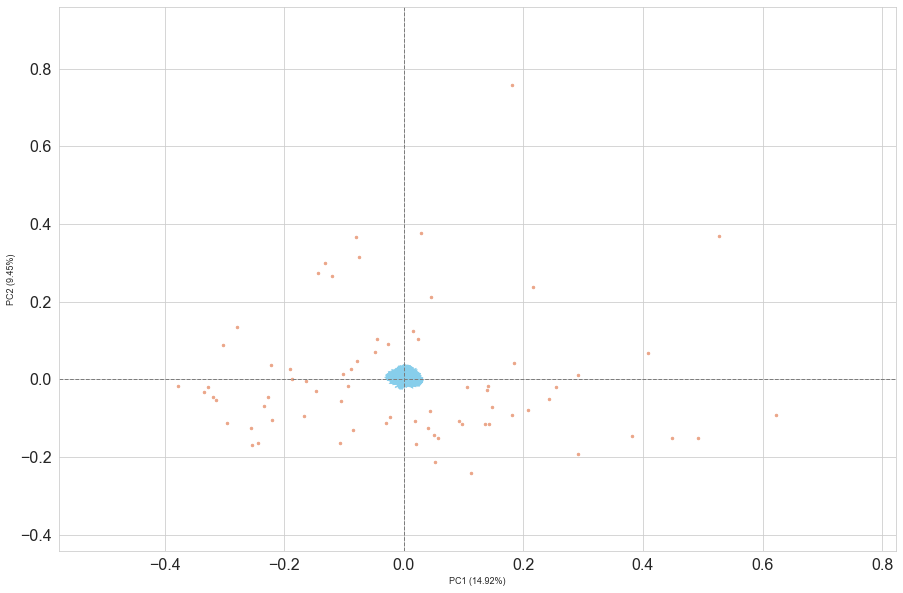

In [16]:
################ Biplot

loadings = pca.components_
cluster.biplot(cscore=pca_emb, loadings=loadings,
               var1=round(pca.explained_variance_ratio_[0]*100, 2),
               var2=round(pca.explained_variance_ratio_[1]*100, 2), 
               labels = ["" for i in range(7222)], 
               show=True,
               dim=(15,10)) # 15% PC1 - 10% PC2

plt.show()

# MDS - Multidimensional scaling

Multidimensional scaling finds an embedding of n objects into a r-dimensional eculidean space so to preserve as well as possible the distances between original objects. it can be performed in a several different ways as classic msd in which the function is called strain and involves directly the original distances between objects; metri mds the function is called stress and involves a function of the original distances and lastly the non-metric mds in which the original distances are dissimilarities, so the stress function finds a non-parametric monotonic relationship between the dissimilarities in the item-item matrix and the euclidean distances between items, and defines the location of each item.

Multidimensional scaling, is known as Principal Coordinates Analysis (PCoA). The data used for multidimensional scaling (MDS) are dissimilarities between pairs of objects. The main objective of MDS is to represent these dissimilarities as distances between points in a low dimensional space such that the distances correspond as closely as possible to the dissimilarities. So MDS, unlike other techinques, don’t use the matrix X but matrix D (a pairwise dissimilarity matrix). Using D, MDS tries to reconstruct X in a lower dimension keeping orginal distances.

PCoA and NMDS use pairwise dissimilarities between data points to find an embedding in Euclidean space that provides the best approximation to the supplied distances. Whereas cMDS is a matrix decomposition method akin to PCA, NMDS is an optimization technique that strives to retain only the ordering of the dissimilarities. The latter approach is more applicable when you have low confidence in the values of the input distances.


- Classic MDS:

It is also known as Principal Coordinates Analysis (PCoA). It takes an input matrix giving dissimilarities between pairs of items and outputs a coordinate matrix whose configuration minimizes a loss function called strain. It is conceptually similar to principal components analysis (PCA) awhich preserve Euclidean and χ2 (chi-squared) distances between objects, respectively; however, PCoA can preserve distances generated from any (dis)similarity measure allowing more flexible handling of complex ecological data. 

- Metric MDS:

It is a superset of classical MDS that generalizes the optimization procedure to a variety of loss functions and input matrices of known distances with weights and so on (called metric MDS if dissimilarities dij are quantitative).

A useful loss function in this context is called stress, which is often minimized using a procedure called stress majorization. The (usual) metric MDS: Given a (low) dimension p and a monotone function f , metric MDS seeks to find an optimal configuration that gives: 

$$f(d_{ij}) = \hat{d_{ij}} = \left \| x_{i} - x_{j} \right \|_{2}$$ as close as possible.

Metric MDS minimizes the cost function called “Stress” which is a residual sum of squares. ‘As close as possible’ is now explicitly stated by square loss:

$$stress = (\sum{i<j} (\hat{d_{ij}} - f(d_{ij}))^{2} / \sum d_{ij}^{2})^{\frac{1}{2}}$$

 
1) Sammon's MDS

Sammon mapping is a generalization of the usual metric MDS. Sammon’s stress (to be minimized) is:

$$Sammon's\ stress\ (\hat{d_{ij}}) = \frac{1}{\sum_{\iota<k} d_{\iota k}} \sum_{i<j} \frac{(\hat{d_{ij}}-d_{ij})^{2}}{d_{ij}}$$

This weighting system normalizes the squared-errors in pairwise distances by using the distance in the original space.
As a result, Sammon mapping preserves the small dij , giving them a greater degree of importance in the fitting procedure
than for larger values of dij. Sammon mapping better preserves inter-distances for smaller dissimilarities, while proportionally squeezes the inter-distances for larger dissimilarities.


- Non Metrics MDS:

In contrast to metric MDS, non-metric MDS finds both a non-parametric monotonic relationship between the dissimilarities in the item-item matrix and the Euclidean distances between items, and the location of each item in the low-dimensional space. Non-metric multidimensional scaling (NMDS) is an indirect gradient analysis approach which produces an ordination based on a distance or dissimilarity matrix. Unlike methods which attempt to maximise the variance or correspondence between objects in an ordination, NMDS attempts to represent, as closely as possible, the pairwise dissimilarity between objects in a low-dimensional space. Any dissimilarity coefficient or distance measure may be used to build the distance matrix used as input.

NMDS is a rank-based approach. This means that the original distance data is substituted with ranks. The relationship is typically found using isotonic regression. Unlike metric MDS, here f is much general and is only
implicitly defined. we tipically use Kruskal’s non-metric MDS that minimizes the stress-1:

$$Kruskal\ stress-1(\hat{d_{ij}}, d^{*}ij) = (\sum_{i<j}  \frac{(\hat{d_{ij}}-d_{ij}^{*})^{2}} {\hat{d_{ij}^{2}}})$$



- General Algorithm:

Step 1 Compute the Gram Matrix:
$$B= -\frac{1}{2} C_{n}D^{2}C_{n}$$

Step 2 Find eigenvalues and eigenvectors of B

Step 3 Use the p eigenvectors corresponding to the p largest eigenvalues of B to construct Xₚ

- MDS vs PCA (apart dissimilarity):

Unlike other ordination methods, MDS makes few assumptions about the nature of the data.For example, principal components analysis assumes linear relationships and reciprocal averaging assumes modal relationshi ps. MDS makes neither of these assumptions, so is well suited for a wide variety of data. MDS also allows the use of any distance measure of the
samples, unlike other methods which specify particular measures, such as covariance or correlation in PCA or the implied chi-squared measure in detrended correspondence analysis. 

- Drawback:

It is said that it is easy to observe empirically that many of the manifold learning methods (like MDS) are not good for data visualization. The reason is that they have been designed to find a d-dimensional manifold if the inherent dimensionality of data is d. For visualization, the display needs to have d = 2 or d = 3; that is, the dimensionality may need to be reduced beyond the inherent dimensionality of data.



In [17]:
components=2

mds = MDS(random_state=42,
          n_components=components, 
          verbose=1)

mds_emb = mds.fit_transform(luce)
mds_df = pd.DataFrame(mds_emb, columns = [f'PC{i+1}' for i in range(components)])
mds_df.head(2)

,PC1,PC2
0,52.919393,69.977881
1,79.787537,50.920510


# Multiple Panel Plots

In [18]:
def umaps(data, k=None, dist=None):
    if k: reducer = umap.UMAP(random_state=42, 
                    n_neighbors= k , 
                    metric='euclidean',
                    n_components=2)
        
    elif dist: reducer = umap.UMAP(random_state=42, 
                    min_dist = dist,
                    metric='euclidean',
                    n_components=2)

    reducer.fit(data)
    embedding = reducer.transform(data)
    return embedding

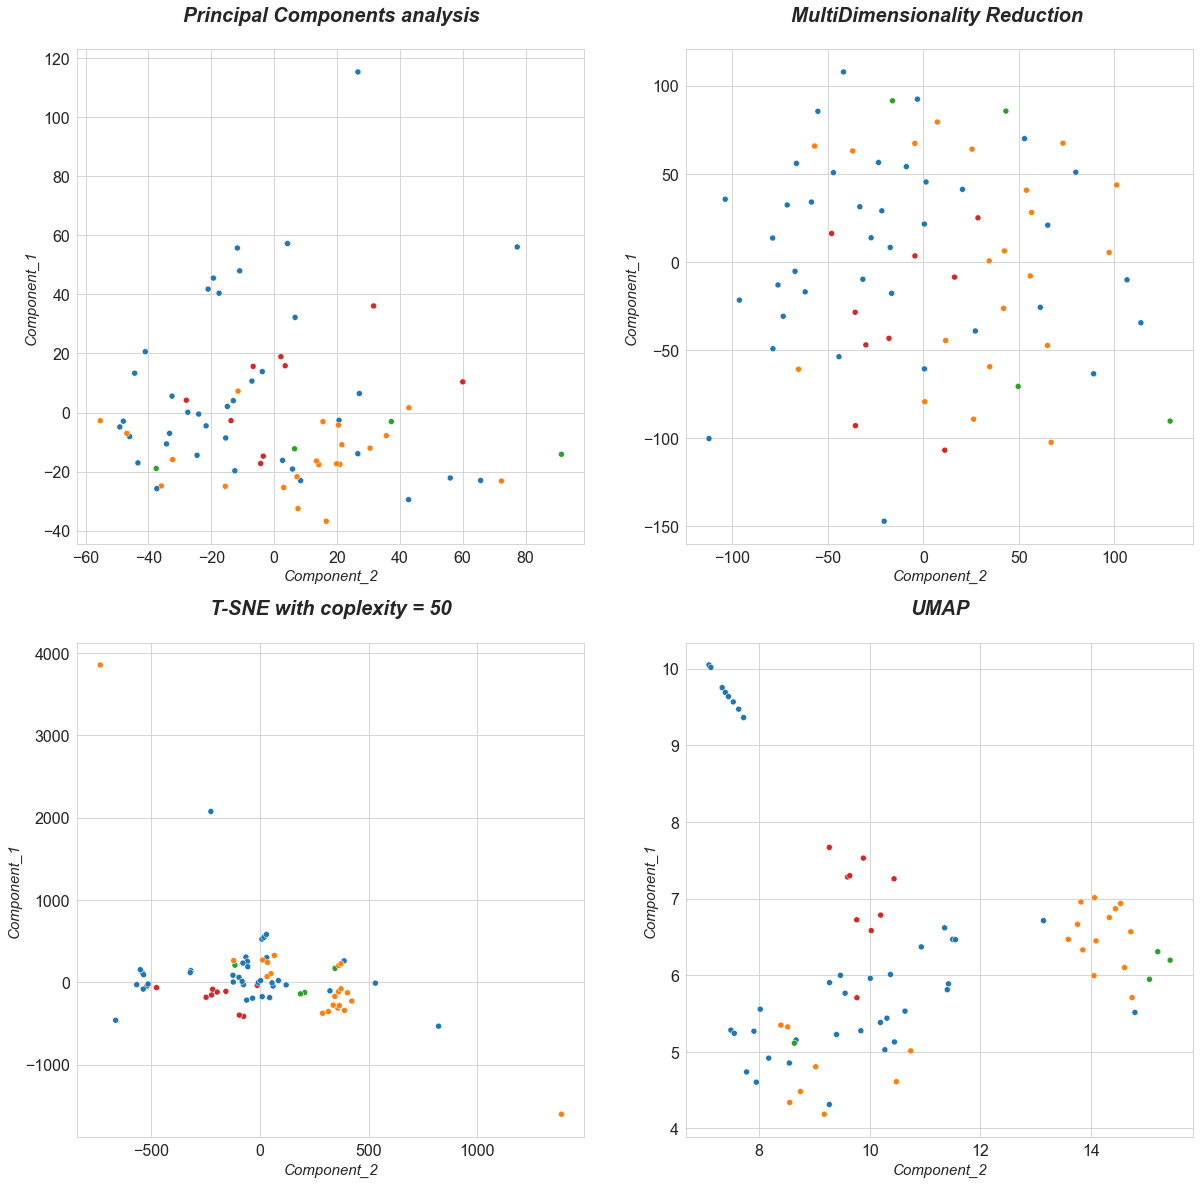

In [20]:
k = [5,50]
multiple_emb = [umaps(luce, k=i) for i in k]
umap_df = pd.DataFrame(multiple_emb[0], columns = [f'PC{i+1}' for i in range(2)])
perpexilities = [2,10,50,100]
multiple_emb = tsnes(luce, 
                     p=perpexilities )

tsne_df = pd.DataFrame(multiple_emb[0], columns = [f'PC{i+1}' for i in range(2)])

fig, axes = plt.subplots(2,2, figsize=(20,20))

style_title= dict(size=20, weight='bold', style='italic')
style_labels = dict(size=15, style='italic')

sns.scatterplot(ax = axes[0][0], data = pca_df, x = 'PC1', y= 'PC2', 
                hue=colors, legend=False)

axes[0][0].set_title("Principal Components analysis\n",  fontdict=style_title)
axes[0][0].set_ylabel("Component_1", fontdict=style_labels)
axes[0][0].set_xlabel("Component_2", fontdict=style_labels)

sns.scatterplot(ax = axes[0][1], data = mds_df, x = 'PC1', y= 'PC2', 
                hue=colors, legend=False)

axes[0][1].set_title("MultiDimensionality Reduction \n",  fontdict=style_title)
axes[0][1].set_ylabel("Component_1", fontdict=style_labels)
axes[0][1].set_xlabel("Component_2", fontdict=style_labels)

sns.scatterplot(ax = axes[1][0], data = tsne_df, x = 'PC1', y= 'PC2', 
               hue=colors, legend=False)

axes[1][0].set_title("T-SNE with coplexity = 50\n",  fontdict=style_title)
axes[1][0].set_ylabel("Component_1", fontdict=style_labels)
axes[1][0].set_xlabel("Component_2", fontdict=style_labels)

sns.scatterplot(ax = axes[1][1], data = umap_df, x = 'PC1', y= 'PC2', 
                hue=colors, legend=False)

axes[1][1].set_title("UMAP\n",  fontdict=style_title)
axes[1][1].set_ylabel("Component_1", fontdict=style_labels)
axes[1][1].set_xlabel("Component_2", fontdict=style_labels)

plt.show()